In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [55]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

from PIL import Image
from IPython.display import display

import tensorflow as tf
from tensorflow.keras import layers, models

from build_model_ed import build_model_1, build_model_2
from get_frames import get_frames

In [4]:
#gpu check
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
#load data
test_size = 0.1
stride_step = 50
norm_factor=1
dtype = 'uint8'

filename = f'save_data/e_d_train_all_str_{stride_step}_ts_{test_size}_{dtype}_norm_{norm_factor}.pkl'
filename = f'save_data/e_d_train_Puck_str_{stride_step}_ts_{test_size}_{dtype}_norm_{norm_factor}.pkl'
filename = f'save_data/e_d_test_Puck_str_{stride_step}_ts_{test_size}_{dtype}_norm_{norm_factor}.pkl'
#load data
with open(filename, 'rb') as f:
    test_list,frames_data_test = pickle.load(f)
    
print(f'Training dataset shape: {frames_data_test.shape}')
print(f'Training dataset dtype: {frames_data_test.dtype}')

Training dataset shape: (3200, 2048, 50, 3)
Training dataset dtype: uint8


In [98]:
model_name = f'model_encoder_decoder_test'
model_name = f'model_encoder_decoder_test_2'
model_name = f'model_encoder_decoder_test_3'
ifPrint = False

filename = f'saved_models/{model_name}_settings.pkl'
#load data
with open(filename, 'rb') as f:
    dense_units,ifBatchNorm,kernel_size,nn_blocks = pickle.load(f)

if ifPrint:
    print(f'Dense units: {dense_units}')
    print(f'ifBatchNorm: {ifBatchNorm}')
    print(f'Kernel size: {kernel_size}')
    nn_blocks_print = "\n".join(map(str, nn_blocks))
    print(f'NN blocks (filters, kernel, ifBatchNorm, MaxPooling): \n{nn_blocks_print}')

    


input_shape = frames_data_test.shape[1:]

print(f'Input shape: {input_shape}')

loss = 'mean_squared_error'
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.1, name="Adadelta")
#optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.01, name="SGD")


model = build_model_2(input_shape, dense_units, nn_blocks)
model.compile(loss=loss, 
              optimizer=optimizer, )
model.summary() 

model.load_weights(f'saved_models/{model_name}/{model_name}')

Input shape: (2048, 50, 3)
Last conv layer shape: (None, 8, 50, 128)
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 2048, 50, 3)]     0         
                                                                 
 rescaling_9 (Rescaling)     (None, 2048, 50, 3)       0         
                                                                 
 conv2d_37 (Conv2D)          (None, 2048, 50, 16)      448       
                                                                 
 batch_normalization_33 (Ba  (None, 2048, 50, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 512, 50, 16)       0         
 ng2D)                                                           
                                                        

In [99]:
#run on test set
batch_size = 2
score = model.evaluate(frames_data_test, frames_data_test, batch_size=batch_size)
print("\nTest score:", score)

1600/1600 [==============================] - 4s 3ms/step - loss: 102.2935

Test score: 102.29354858398438


1/1 [==============================] - 0s 122ms/step


Text(0.5, 1.0, 'Prediction')

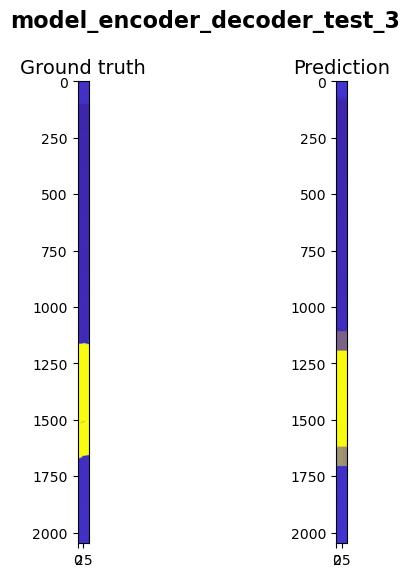

In [100]:
#compare results for the chosen fram from the test set
frame_index = 100
#get frame
frame_to_predict = frames_data_test[frame_index]
#make prediction
frame_predicted = model.predict(np.expand_dims(frame_to_predict, axis=0))
#change dtype to int
#TODO fix scaler layer of a NN to output int not float
frame_predicted = frame_predicted[0].astype(int)

fig, axes = plt.subplots(1,2, figsize=(6,6))
fig.subplots_adjust(hspace=0.2, wspace=0.25)
linewidth = 3.0
fontsize_sec = 14
fig.suptitle(f'{model_name}', fontsize=fontsize_sec+2, fontweight='bold', y=1)

ax = axes[0]
ax.imshow(frame_to_predict)
ax.set_title(f'Ground truth', fontsize=fontsize_sec)

ax = axes[1]
ax.imshow(frame_predicted)
ax.set_title(f'Prediction', fontsize=fontsize_sec)

Chosen test case: Pucker29.png

Image shape: (2048, 4000, 3)
Framed image shape: (80, 2048, 50, 3)
##########Prediction started#############
1/1 [==============================] - 0s 13ms/step
##########Image predicted#############

Reshaping separate frames into a single image
Image shape after 1st reshape: (80, 50, 2048, 3)
Image shape after 2st reshape: (4000, 2048, 3)
Image shape after final reshape: (2048, 4000, 3)


Text(0.5, 1.0, 'Prediction')

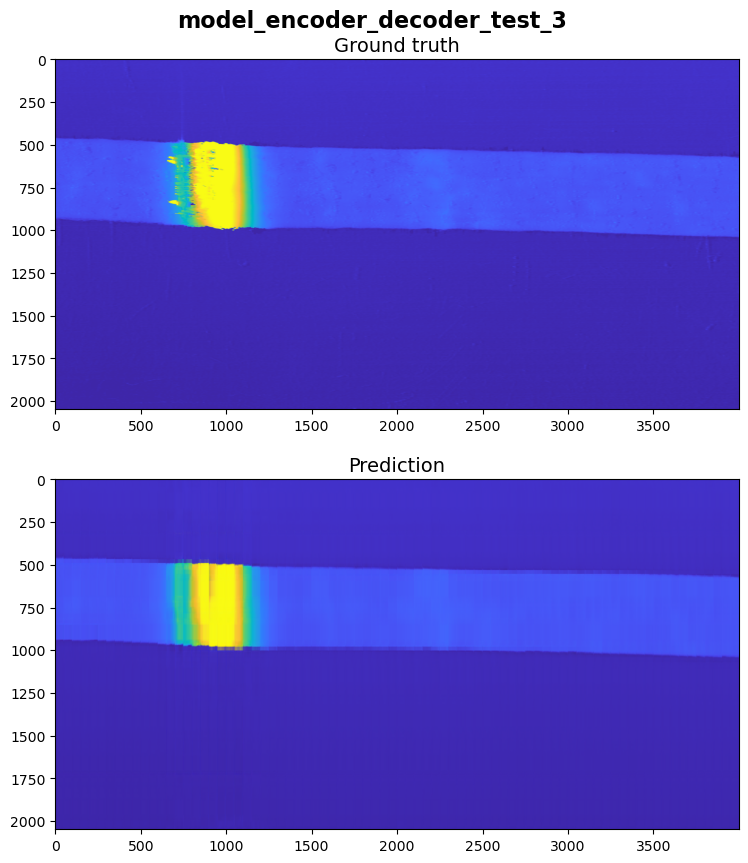

In [101]:
test_case = test_list[0]
stride_step = 50
print(f'Chosen test case: {test_case}\n')


path_list = ['PuckerImages//RGB_cropped',
             'TwistImages//RGB',
             'FoldImages//RGB',]
for path in path_list:
    if test_case[:4]==path[:4]:
        break

img = Image.open(f'{path}//{test_case}')
image_data_gt = np.array(img, dtype=dtype)
#crop the end
image_data_gt = image_data_gt[:,:-96,:]
print(f'Image shape: {image_data_gt.shape}')
#get frames
image_data_frames_gt = get_frames(image_data_gt, stride_step, ifPrint = False)
print(f'Framed image shape: {image_data_frames_gt.shape}')

#prediction
print('##########Prediction started#############')
for i, frame_data_gt in enumerate(image_data_frames_gt):
    frame_data_predicted = model.predict(np.expand_dims(frame_data_gt, axis=0))
    
    if i==0:
        image_data_frames_predicted = frame_data_predicted
    else:
        image_data_frames_predicted = np.append(image_data_frames_predicted, frame_data_predicted, axis=0)
        
print('##########Image predicted#############')

#reshape from separate frames into a single image
print('\nReshaping separate frames into a single image')
original_shape = image_data_frames_predicted.shape
#swap axis
image_data_rsh1 = np.swapaxes(image_data_frames_predicted,1,2)
print(f'Image shape after 1st reshape: {image_data_rsh1.shape}')
#reshape
image_data_rsh2 = image_data_rsh1.reshape(original_shape[0]*original_shape[2], original_shape[1], original_shape[3])
print(f'Image shape after 2st reshape: {image_data_rsh2.shape}')
#swap axis back
image_data_predicted = np.swapaxes(image_data_rsh2,0,1)
print(f'Image shape after final reshape: {image_data_predicted.shape}')
#convert float to in
image_data_predicted=image_data_predicted.astype(int)


fig, axes = plt.subplots(2,1, figsize=(20,10))
fig.subplots_adjust(hspace=0.2, wspace=0.25)
linewidth = 3.0
fontsize_sec = 14
fig.suptitle(f'{model_name}', fontsize=fontsize_sec+2, fontweight='bold', y=0.93)

ax = axes[0]
ax.imshow(image_data_gt)
ax.set_title(f'Ground truth', fontsize=fontsize_sec)

ax = axes[1]
ax.imshow(image_data_predicted)
ax.set_title(f'Prediction', fontsize=fontsize_sec)